# Quantitative Analysis


### BRK.A Vs. LVMUY

Computing advanced statistical methods to understand, analyze, and compare the inherent risk in two stocks with Bollinger bands, Conditional Value at Risk, Kurtosis analysis, Shapiro-Wilk normality test, and back-test maximum drawdown.

In [153]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


### Data

In [41]:
# Utility Function
def ticker_to_path(ticker, base_dir="BRK"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(ticker)))


def get_data(tickers, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in tickers:  # add SPY for reference, if absent
        tickers.insert(0, 'SPY')

    for ticker in tickers:
        df_temp = pd.read_csv(ticker_to_path(ticker), 
                              index_col="Date", 
                              parse_dates=True,
                              usecols=['Date','Adj Close'],
                       na_values=['nan'])
        
        df_temp = df_temp.rename(columns={'Adj Close': ticker})
        df = df.join(df_temp)
        if ticker == 'SPY': #Drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df

# Define a date range
dates = pd.date_range('2017-12-12', '2018-12-14')

# Choose stock symbols to read
tickers = ["BRK-A","LVMUY"]

# Get stock data
df = get_data(tickers, dates)
    
df = df.dropna(how="any")

df.rename(columns={'BRK-A': 'BRK_A'}, inplace=True)

In [122]:
# forms of data
prices = df.iloc[1:]
returns = np.log(df / df.shift(1)).iloc[1:]

In [347]:
def beta_brk(returns):
    # Create a matrix of [returns, market]
    brk_m = returns.cov().iloc[0,1]

    # Return the covariance of m divided by the standard deviation of the market returns
    return brk_m / returns['SPY'].var()

def beta_lvmuy(returns):
    # Create a matrix of [returns, market]
    lvmuy_m = returns.cov().iloc[0,2]

    # Return the covariance of m divided by the standard deviation of the market returns
    return lvmuy_m / returns['SPY'].var()

print("Annualized Beta for BRK.A: ",beta_brk(returns))
print("Annualized Beta for LVMUY: ",beta_lvmuy(returns))

Annualized Beta for BRK.A:  1.09569339665
Annualized Beta for LVMUY:  1.12631274544


### Bollinger Bands

In this part,we compute advanced statistical methods to analyze the investment horizon for both stocks in the past trading-year (252 days). We first introduce the Bollinger bands as a technical indicator for the behavior of the volatility and to explain mean-reversion for both stocks. Bollinger bands consist of computing the moving average for the adjusted closing price for BRK.A in a rolling basis of 21 days (monthly) and computing rolling standard deviations of the price. The upper band represents two standard deviations above the moving average and the lower band represents two standard deviations below the moving average.

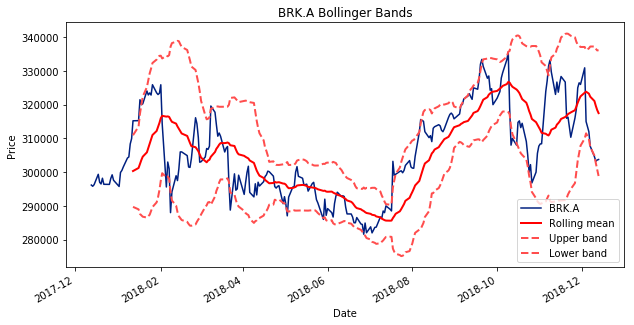

In [348]:
# moving averages (21 days)
# Compute Rolling mean using 21 days window.
rm_brk = prices["BRK_A"].rolling(window=21, center=False).mean()

rstd_brk = prices["BRK_A"].rolling(window=21, center=False).std()

upper_band = rm_brk + rstd_brk * 2
lower_band = rm_brk - rstd_brk * 2

# Plot BRK values, rolling mean and Bollinger Bands
plt.figure(figsize=(10,5))
ax = prices['BRK_A'].plot(title="BRK.A Bollinger Bands", label='BRK.A',color="#002080")
rm_brk.plot(label='Rolling mean', ax=ax, color="r",linewidth=2)
upper_band.plot(label='Upper band', ax=ax,linewidth=2,color="#ff4d4d",style='--')
lower_band.plot(label='Lower band', ax=ax,linewidth=2,color="#ff4d4d",style='--')

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='lower right')
plt.savefig('BRK-A bb.png', dpi=300,bbox_inches='tight')

As seen in the figure above, we observe that BRK.A’s Bollinger bands expand for the first months of the year, then contracting significantly, and lastly starting to expand again. This behavior shows us that BRK.A’s price has an expected incremental volatility which increases perceived risk, and as a result, trading opportunities for statistical arbitrage and other methods. 

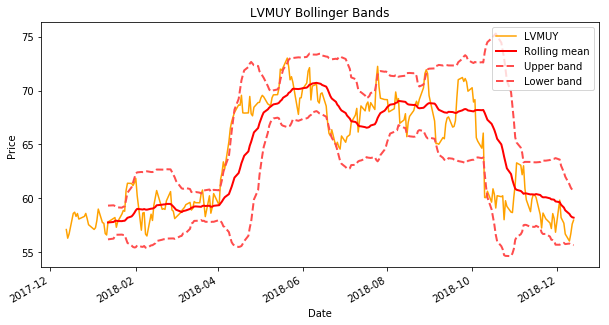

In [349]:
# Compute Rolling mean using 21 days window.
rm_brk = prices["LVMUY"].rolling(window=21, center=False).mean()

rstd_brk = prices["LVMUY"].rolling(window=21, center=False).std()

upper_band = rm_brk + rstd_brk * 2
lower_band = rm_brk - rstd_brk * 2

# Plot BRK values, rolling mean and Bollinger Bands
plt.figure(figsize=(10,5))
ax = prices['LVMUY'].plot(title="LVMUY Bollinger Bands", label='LVMUY',color="#FFA200")
rm_brk.plot(label='Rolling mean', ax=ax, color="r",linewidth=2)
upper_band.plot(label='Upper band', ax=ax,linewidth=2,color="#ff4d4d",style='--')
lower_band.plot(label='Lower band', ax=ax,linewidth=2,color="#ff4d4d",style='--')

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper right')

plt.savefig('LVMUY bb.png', dpi=300,bbox_inches='tight')

In figure 2 we observe LVMUY’s volatility behavior, with a similar behavior to the volatility of BRK.A, LVMUY’s volatility expands, contracts, and starts expanding back again for the remaining of the year. 

### Risk Management

#### Logarithmic Return distributions, Value at Risk and Conditional Value at Risk 

We then compute the logarithmic returns (log) for each stock to model Value at Risk (VaR). For this, we take the natural logarithm of the division between the current price and the previous price. This will give us a lognormal distribution of returns. With the log returns, we can plot a sorted distribution into a probability density function (PDF) to explain the VaR for a one-day period and the expected shortfall (CVaR) for a more coherent risk measurement for each stock. For all the VaR and CVaR computations, we use a 95% confidence interval. 

5.0% VaR threshold: -1.9107
5.0% CVaR: -3.561
Kurtosis: 4.38235662353
skewness: -0.543748589503


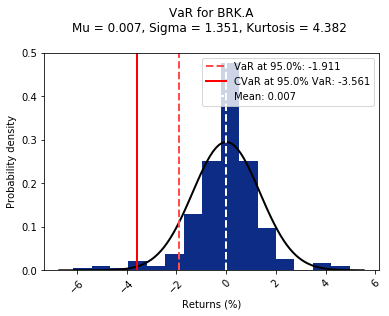

In [350]:
# VaR parameters
brk_ret = returns['BRK_A']
lvmuy_ret = returns['LVMUY']

distribution = brk_ret*100
confidence = 5
last_value = brk_ret.mean()*100

# Value at Risk
price_array = distribution.sort_values(ascending=True)
var_percentile = np.percentile(price_array, confidence)
val_at_risk = last_value - var_percentile

# CVaR
cvar = price_array[price_array <= var_percentile].mean()

# print
var_percentile_95 = np.percentile(price_array, 5)

val_at_risk_95 = last_value - var_percentile_95

print("5.0% VaR threshold:",round(var_percentile_95,4))

# Conditional VaR
cvar_95 = price_array[price_array <= var_percentile_95].mean()
c_val_at_risk_95 = last_value - cvar_95

print("5.0% CVaR:",round(cvar_95,4))

# Probabilistic Density Function
mu = price_array.mean() 
sigma = price_array.std()  
kurtosis = price_array.kurtosis()
skewness = price_array.skew()
num_bins = int(np.sqrt(len(distribution)))

print("Kurtosis:",kurtosis)
print("skewness:",skewness)
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#002080",label='',alpha=0.95)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Returns (%)')
plt.xticks(rotation=45)
plt.yticks()
plt.ylabel('Probability density')
ax.set_title("VaR for BRK.A\nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu,sigma,kurtosis), fontsize=12)
#plt.title(r'VaR for Simulated Prices', fontsize=18, fontweight='bold')
plt.axvline(x=var_percentile, color='#ff4d4d', linestyle='--',linewidth=2, label='VaR at {}%: '.format(str(float(100-confidence))) + str(round(var_percentile,3)))
plt.axvline(x=cvar, color='r', linestyle='-',linewidth=2, label='CVaR at {}% VaR: '.format(str(float(100-confidence))) + str(round(cvar,3)))
plt.axvline(x=last_value, color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(last_value,3)))
ax.set_facecolor('w')
plt.legend(loc="upper right")
plt.savefig('BRK_a Var.png', dpi=300,bbox_inches='tight')


In figure 3, we observe the logarithmic return distribution for BRK.A with a value at risk at -1.91% and an expected shortfall of -3.56%. The returns have an annualized daily return of 0.007% and an annualized volatility of 1.35% and a Sharpe ratio of 0.005. 

5.0% VaR threshold: -3.0354
5.0% CVaR: -4.3025
Kurtosis: 3.14499329107
skewness: -0.81441743114


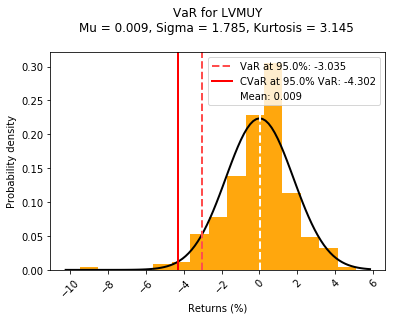

In [358]:
# VaR parameters
distribution = lvmuy_ret*100
confidence = 5
last_value = lvmuy_ret.mean()*100

# Value at Risk
price_array = distribution.sort_values(ascending=True)
var_percentile = np.percentile(price_array, confidence)
val_at_risk = last_value - var_percentile

# CVaR
cvar = price_array[price_array <= var_percentile].mean()

# print
var_percentile_95 = np.percentile(price_array, 5)

val_at_risk_95 = last_value - var_percentile_95

print("5.0% VaR threshold:",round(var_percentile_95,4))

# Conditional VaR
cvar_95 = price_array[price_array <= var_percentile_95].mean()
c_val_at_risk_95 = last_value - cvar_95

print("5.0% CVaR:",round(cvar_95,4))

# Probabilistic Density Function
mu = price_array.mean() 
sigma = price_array.std()  
kurtosis = price_array.kurtosis()
skewness = price_array.skew()
num_bins = int(np.sqrt(len(distribution)))

print("Kurtosis:",kurtosis)
print("skewness:",skewness)
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#FFA200",label='',alpha=0.95)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Returns (%)')
plt.xticks(rotation=45)
plt.yticks()
plt.ylabel('Probability density')
ax.set_title("VaR for LVMUY\nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu,sigma,kurtosis), fontsize=12)
#plt.title(r'VaR for Simulated Prices', fontsize=18, fontweight='bold')
plt.axvline(x=var_percentile, color='#ff4d4d', linestyle='--',linewidth=2, label='VaR at {}%: '.format(str(float(100-confidence))) + str(round(var_percentile,3)))
plt.axvline(x=cvar, color='r', linestyle='-',linewidth=2, label='CVaR at {}% VaR: '.format(str(float(100-confidence))) + str(round(cvar,3)))
plt.axvline(x=last_value, color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(last_value,3)))
ax.set_facecolor('w')
plt.legend(loc="upper right")
plt.savefig('LVMUY Var.png', dpi=300,bbox_inches='tight')

In figure 4, we notice the logarithmic returns distribution for LVMUY with a VaR of -3.03% and a CVaR of -4.30% and an annualized return of 0.009 with an annualized volatility of 1.78%  and a Sharpe ratio of 0.0048. The risk measurements for each stock denote that at a one-day period, the stocks have a probability of reaching a potential loss up till the VaR threshold previously explained. With the CVaR, we can explain a more coherent measurement of the expected shortfall or the maximum risk at a given day (without counting total loss), as it takes into consideration the average of all the negative returns surpassing the VaR threshold. In this case, we can observe that BRK.A has a VaR and CVaR threshold set higher than that of LVMUY’s, explaining that with a constant probability of an expected shortfall for the following day, LVMUY is much more exposed to a greater loss. We also computed the annualized beta for each stock’s return, using SPY as the benchmark. BRK.A got an annualized beta of 1.35 and LVMUY an annualized beta of 1.78. With this, we could further comprehend LVMUY’s higher volatility than that of the US market’s primary benchmark. 

### Returns Normality 

#### Normality Test

For a more detailed analysis in the behavior of the logarithmic returns distribution for each stock, we introduce the following statistical methods to understand the distribution of returns for the past 252 days: excess kurtosis, skewness, and Shapiro-Wilk test. 

In [352]:
# Testing for normality on returns
from scipy import stats

# BRK.A Normality
print("BRK.A Kurtosis: ", brk_ret.kurtosis())
print("BRK.A Skewness: ", brk_ret.skew())

p_value = stats.shapiro(brk_ret)[1] 

if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.") 
else:
    print("Null hypothesis of normality is accepted.")

# LVMUY Normality
print("\nLVMUY Kurtosis: ", lvmuy_ret.kurtosis())
print("LVMUY Skewness: ", lvmuy_ret.skew())

p_value = stats.shapiro(lvmuy_ret)[1] 

if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.") 
else:
    print("Null hypothesis of normality is accepted.")


BRK.A Kurtosis:  4.38235662353
BRK.A Skewness:  -0.543748589503
Null hypothesis of normality is rejected.

LVMUY Kurtosis:  3.14499329107
LVMUY Skewness:  -0.81441743114
Null hypothesis of normality is rejected.


For BRK.A we obtained an excess kurtosis of 4.38, this means that the distribution of returns for BRK.A has much more exposure in the tails and diverges significantly from the excess kurtosis of a normal distribution which is 0. In the case of LVMUY, its excess kurtosis is of 3.14, which still explains a high level of kurtosis. These levels of kurtosis describe both BRK.A and LVMUY’s returns highly leptokurtic. Furthermore, the skewness of BRKA’s returns is -0.54 and -0.81 for LVMUY’s. the negative skewness describes that the mass of the return distributions is concentrated on the right and therefore makes them right-leaning curves. By being right-leaning, the probability density of negative returns is much higher for both stocks.  Finally, we use the statistical Shapiro-Wilk test. This test has its null hypothesis that the distribution is normally distributed. We compute the p-value for each distribution and set the p-value threshold to a confidence interval of 95%. In the results, we got that both distributions have their null hypothesis rejected. This finally concludes that neither stock return distribution behaves in a normal way. 

### Maximum Drawdown

Lastly, we compute the rolling cumulative returns for each stock to find the maximum drawdown for the past trading-year as a last risk measurement. Maximum drawdown explains the longest gap between the highest peak and lowest trough. 

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


BRK.A's maximum drawdown starting from 2018-01-26 to 2018-06-27 with a duration of 152 days 00:00:00.
BRK.A's Maximum drawdown of 14.61%.


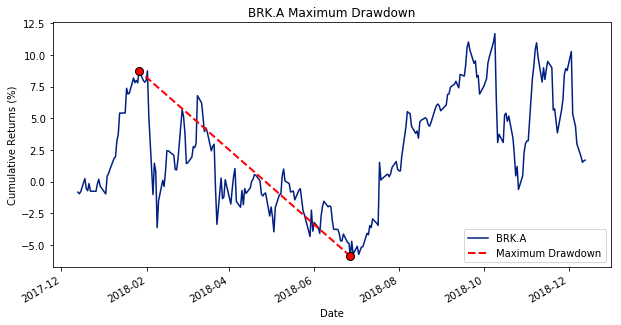

In [356]:
# Maximum drawdown for BRK.A

# Calculating daily drawdowns for the past year
cum_rets = np.cumsum(brk_ret)*100

end = np.argmax(np.maximum.accumulate(cum_rets) - cum_rets) # end of the period
start = np.argmax(cum_rets[:end]) # start of period

plt.figure(figsize=(10,5))
ax = cum_rets.plot(title="BRK.A Maximum Drawdown",color="#002080",label='BRK.A') 
plt.plot([end, start], [cum_rets[end], cum_rets[start]], '--', color='Red', markersize=10,label='Maximum Drawdown',linewidth=2)
plt.plot([end, start], [cum_rets[end], cum_rets[start]], 'o', color='Red', markersize=8,markeredgecolor='k')

maximum_dd = abs(cum_rets[end]- cum_rets[start])
print("BRK.A's maximum drawdown starting from {} to {} with a duration of {}.".format(start.date(),end.date(),end-start))
print("BRK.A's Maximum drawdown of {}%.".format(round(maximum_dd,2)))

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns (%)")
ax.legend(loc='lower right')
plt.savefig('BRK-A mdd.png', dpi=300,bbox_inches='tight')

In the case of BRK.A, we can observe that the maximum drawdown in this year started in January 26 of 2018 and ended in June 27 of the same year with a duration of 152 days. The maximum drawdown for BRK.A in percentage was of 14.61%. 

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


LVMUY's maximum drawdown starting from 2018-05-21 to 2018-12-10 with a duration of 203 days 00:00:00.
LVMUY's Maximum drawdown of 26.51%.


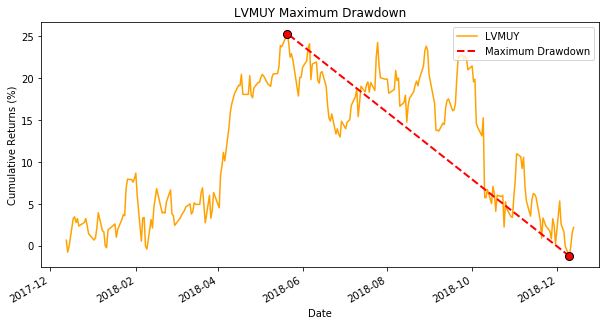

In [357]:
# Maximum Drawdown for LVMUY

# Calculating daily drawdowns for the past year
cum_rets = np.cumsum(lvmuy_ret)*100

end = np.argmax(np.maximum.accumulate(cum_rets) - cum_rets) # end of the period
start = np.argmax(cum_rets[:end]) # start of period

plt.figure(figsize=(10,5))
ax = cum_rets.plot(title="LVMUY Maximum Drawdown",color="#FFA200",label='LVMUY') 
plt.plot([end, start], [cum_rets[end], cum_rets[start]], '--', color='Red', markersize=10,label='Maximum Drawdown',linewidth=2)
plt.plot([end, start], [cum_rets[end], cum_rets[start]], 'o', color='Red', markersize=8,markeredgecolor='k')

maximum_dd = abs(cum_rets[end]- cum_rets[start])
print("LVMUY's maximum drawdown starting from {} to {} with a duration of {}.".format(start.date(),end.date(),end-start))
print("LVMUY's Maximum drawdown of {}%.".format(round(maximum_dd,2)))

# Add axis labels and legends
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns (%)")
ax.legend(loc='upper right')
plt.savefig('LVMUY mdd.png', dpi=300,bbox_inches='tight')

In the case of LVMUY, the maximum drawdown in this year started from May 21st 2018 to December 10th of the same year with a duration of 203 days. The maximum drawdown for LVMUY in percentage was of 26.51%. With this, we conclude LVMUY’s high and long-lasting maximum drawdown as our last factor to determine LVMUY’s much riskier investment based in the back-testing period for the past trading-year. 

### Performance

In [355]:
# Risk adjusted returns

# Sharpe Ratio BRK.A
cagr_b = brk_ret.mean()
vol_b = brk_ret.std()
sharpe_b = cagr_b/vol_b
print("CAGR for BRK.A: ", round(cagr_b*100,4))
print("Volatility for BRK.A: ", round(vol_b*100,4))
print("Sharpe for BRK.A: ", round(sharpe_b,4))

# Sharpe Ratio LVMUY
cagr_l = lvmuy_ret.mean()
vol_l = lvmuy_ret.std()
sharpe_l = cagr_l/vol_l
print("\nCAGR for LVMUY: ", round(cagr_l*100,4))
print("Volatility for LVMUY: ", round(vol_l*100,4))
print("Sharpe for LVMUY: ", round(sharpe_l,4))

CAGR for BRK.A:  0.0067
Volatility for BRK.A:  1.3512
Sharpe for BRK.A:  0.005

CAGR for LVMUY:  0.0086
Volatility for LVMUY:  1.7848
Sharpe for LVMUY:  0.0048
